<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# Evaluating k-means clustering
Estimated time needed: **30** minutes
    

## Objectives

After completing this lab you will be able to:

* Implement and evaluate the performance of k-means clustering on synthetic data
* Interpret various evaluation metrics and visualizations
* Compare clustering results against known classes unsing synthetic data


## Introduction
In this lab you will:
- Generate synthetic data for running targeted experiments using scikit-learn
- Create k-means models and evaluate their comparative performance
- Investigate evaluation metrics and techniques for assessing clustering results 

Your goal in this lab is primarily for you to gain some intuition around the subjective problem of finding good clustering solutions.


## Import the required libraries


In [1]:
!pip install numpy==2.2.0
!pip install pandas==2.2.3
!pip install scikit-learn==1.6.0
!pip install matplotlib==3.9.3
!pip install scipy==1.14.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 140.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 143.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 151.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 109.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 164.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 131.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Patch
from matplotlib import cm

### Clustering evaluation function
We'll define a function for evaluating the clustering models we'll be building.
We'll include silhouette scores and the Davies-Bouldin index, plus generate a plot displaying the silhouette scores


In [3]:
def evaluate_clustering(X, labels, n_clusters, ax=None, title_suffix=''):
    """
    Evaluate a clustering model using silhouette scores and the Davies-Bouldin index.
    
    Parameters:
    X (ndarray): Feature matrix.
    labels (array-like): Cluster labels assigned to each sample.
    n_clusters (int): The number of clusters in the model.
    ax: The subplot axes to plot on.
    title_suffix (str): Optional suffix for plot titlec
    
    Returns:
    None: Displays silhoutte scores and a silhouette plot.
    """
    if ax is None:
        ax = plt.gca()  # Get the current axis if none is provided
    
    # Calculate silhouette scores
    silhouette_avg = silhouette_score(X, labels)
    sample_silhouette_values = silhouette_samples(X, labels)

    # Plot silhouette analysis on the provided axis
    unique_labels = np.unique(labels)
    colormap = cm.tab10
    color_dict = {label: colormap(float(label) / n_clusters) for label in unique_labels}
    y_lower = 10
    for i in unique_labels:
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = color_dict[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax.set_title(f'Silhouette Score for {title_suffix} \n' + 
                 f'Average Silhouette: {silhouette_avg:.2f}')
    ax.set_xlabel('Silhouette Coefficient')
    ax.set_ylabel('Cluster')
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_xlim([-0.25, 1])  # Set the x-axis range to [0, 1]

    ax.set_yticks([])


## Create synthetic data with four blobs to experiment with k-means clustering
Here we'll make some synthetic data consisting of slightly overlapping blobs, then run and evaluate k-means with k=4 clusters.


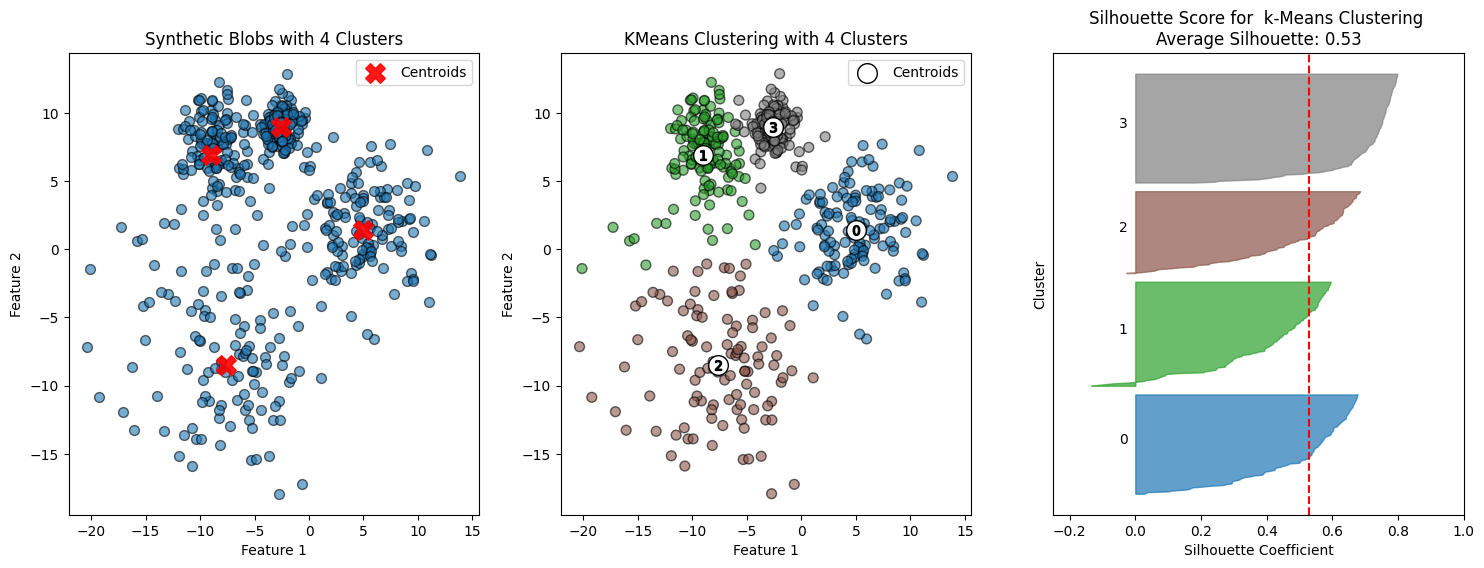

In [4]:
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=[1.0, 3, 5, 2], random_state=42)

# Apply KMeans clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_kmeans = kmeans.fit_predict(X)

colormap = cm.tab10

# Plot the blobs
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], s=50, alpha=0.6, edgecolor='k')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', alpha=0.9, label='Centroids')
plt.title(f'Synthetic Blobs with {n_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Plot the clustering result
# Create colors based on the predicted labels
colors = colormap(y_kmeans.astype(float) / n_clusters)

plt.subplot(1, 3, 2)
plt.scatter(X[:, 0], X[:, 1], c=colors, s=50, alpha=0.6, edgecolor='k')

# Label the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
    label='Centroids'
)
# Label the custer number
for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

plt.title(f'KMeans Clustering with {n_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Evaluate the clustering
plt.subplot(1, 3, 3)
evaluate_clustering(X, y_kmeans, n_clusters, title_suffix=' k-Means Clustering')
plt.show()


Each point in a silhouette plot has a silhouette score ranging from -1 to 1. A high silhouette score indicates the data point is much more similar to its own cluster than its neighboring clusters. A score near 0 implies the point is at or near the decision boundary between two clusters. A negative score means the point might have been assigned to the wrong cluster. We'll take a closer look at the silhoutte plot later.

The clustering result is quite plausible, particularly because we already know that there are four blobs in the synthetic data. Practically hoeever, we would not have such information.


## Cluster Stability
How do the results change when K-means is run using different initial centroid seeds?

To assess stability, we can measure *inertia* and repeatedly vary the random initialization of cluster centers to observe the impact of having different intitial centroid locations.

Inertia measures the compactness of clusters in K-means. It is defined as the sum of squared distances between each data point and its cluster centroid. Lower inertia values indicate more compact clusters and a potentially better clustering outcome. However, inertia tends to decrease as the number of clusters increases, so it's important to interpret it alongside other metrics.

To evaluate the stability of clustering, running k-means multiple times with different initial centroids by not fixing the random state helps determine if the algorithm consistently produces similar cluster assignments and inertia scores. Consistent inertia across runs suggests a stable solution that is less dependent on initial centroid positions.


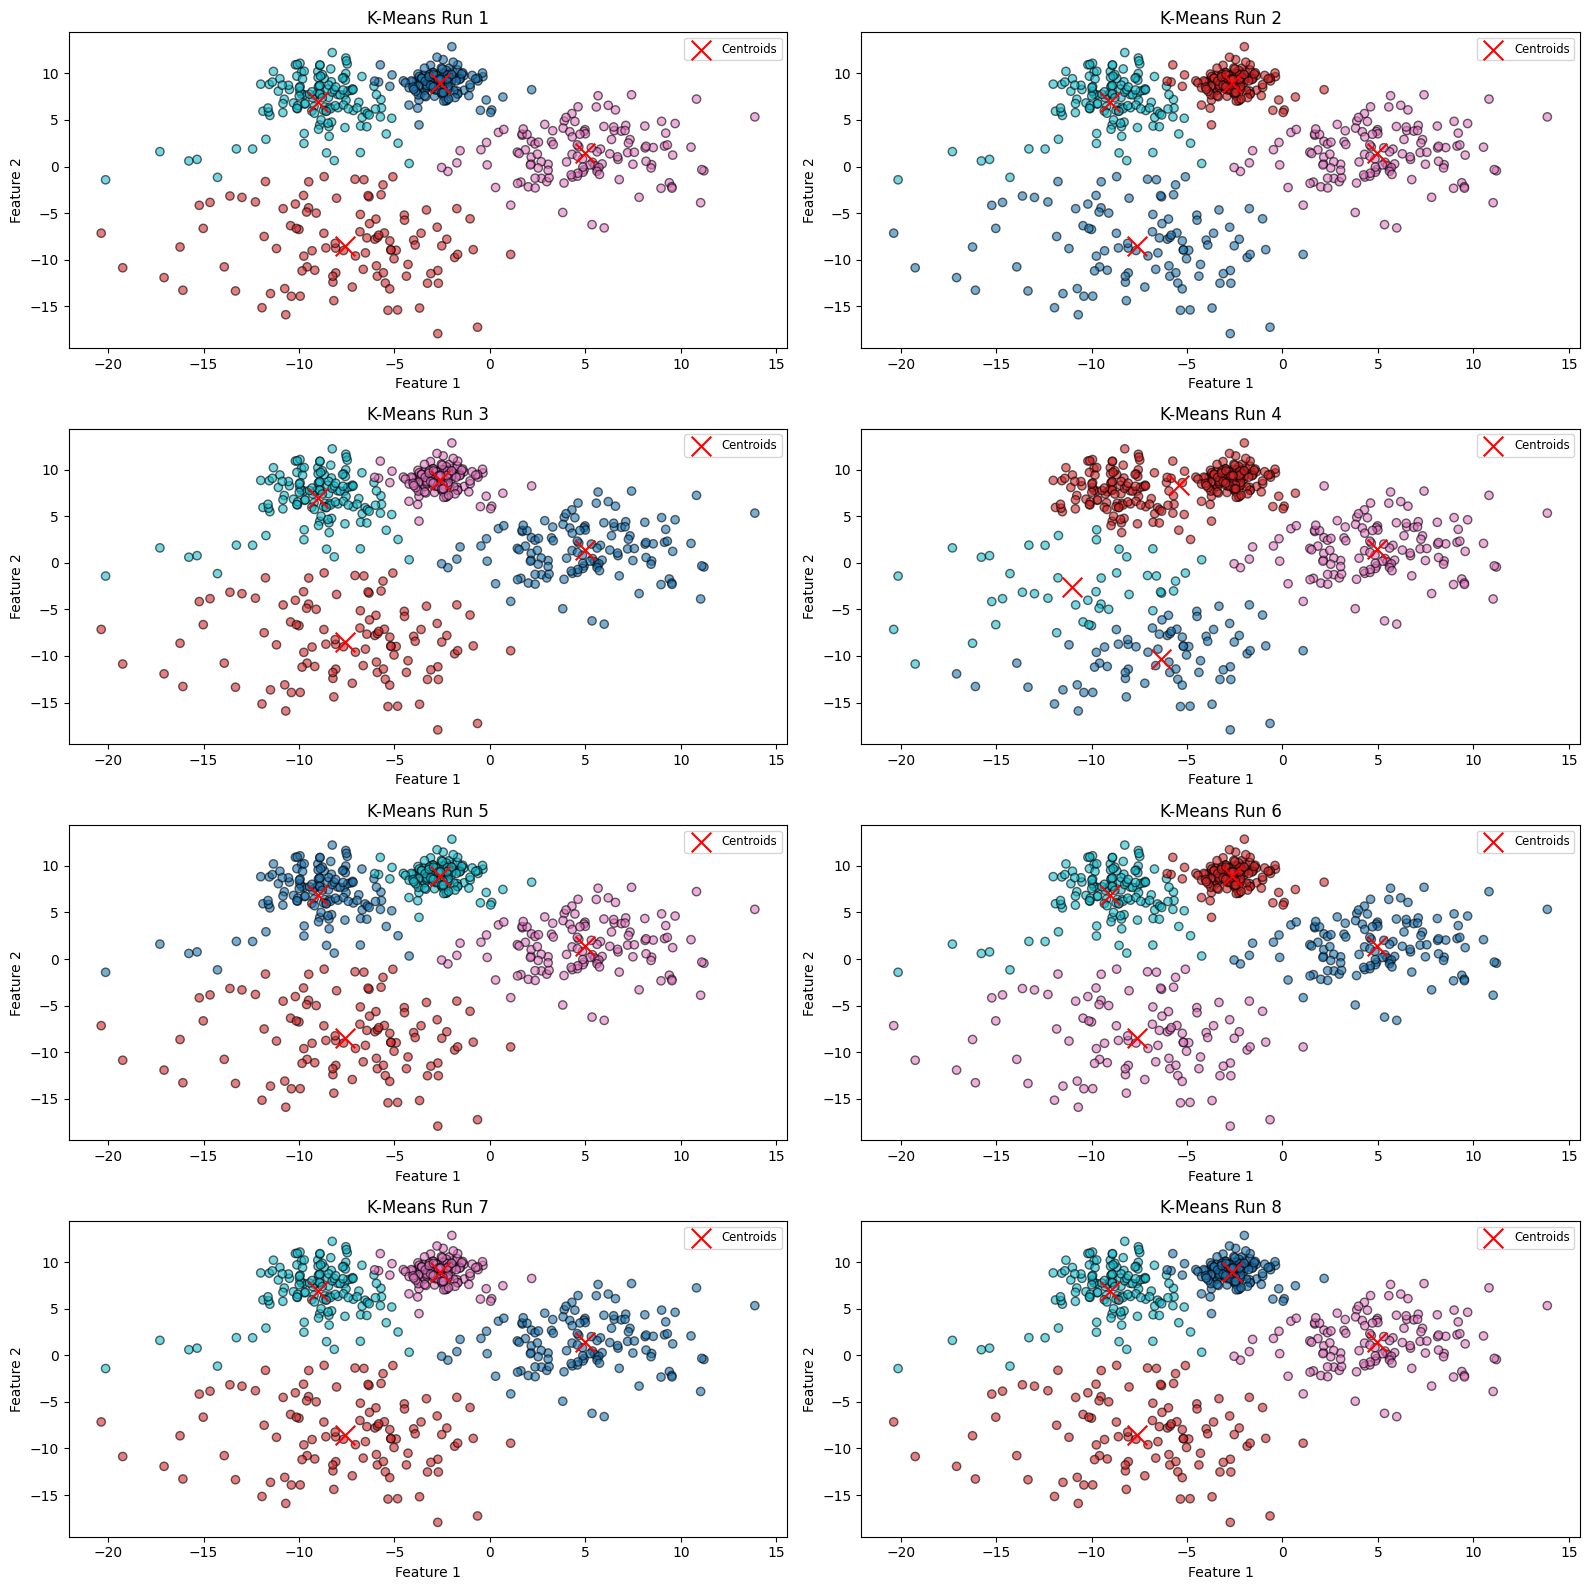

Run 1: Inertia=7633.51
Run 2: Inertia=7633.51
Run 3: Inertia=7633.51
Run 4: Inertia=8556.67
Run 5: Inertia=7633.51
Run 6: Inertia=7633.51
Run 7: Inertia=7633.51
Run 8: Inertia=7633.51


In [5]:
# Number of runs for k-means with different random states
n_runs = 8
inertia_values = []

# Calculate number of rows and columns needed for subplots
n_cols = 2 # Number of columns
n_rows = -(-n_runs // n_cols) # Ceil division to determine rows
plt.figure(figsize=(16, 16)) # Adjust the figure size for better visualization

# Run K-Means multiple times with different random states
for i in range(n_runs):
    kmeans = KMeans(n_clusters=4, random_state=None)  # Use the default `n_init`
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

    # Plot the clustering result
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='tab10', alpha=0.6, edgecolor='k')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='x', label='Centroids')
    plt.title(f'K-Means Run {i + 1}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

# Print inertia values
for i, inertia in enumerate(inertia_values, start=1):
    print(f'Run {i}: Inertia={inertia:.2f}')

### Exercise 1. What can you say about this result?


<details><summary>Click here for some observations</summary>
As demonstrated by the clustering results, the cluster assignments vary between runs when using different initial centroid seeds. Additionally, the inertia values show inconsistency, indicating that the clustering process is sensitive to the initial placement of centroids. This inertial inconsistency implies an less reliable result. 


## Number of clusters
How do performance metrics change as the number of clusters increases?

Can this analysis guide you in determining the optimal number of clusters?

To explore this, we can examine how varying the value of K affects key metrics such as inertia, the Davies-Bouldin index, and silhouette scores. By plotting these scores as a function of K, we can analyze the results and potentially gain insights into the optimal number of clusters for our data.


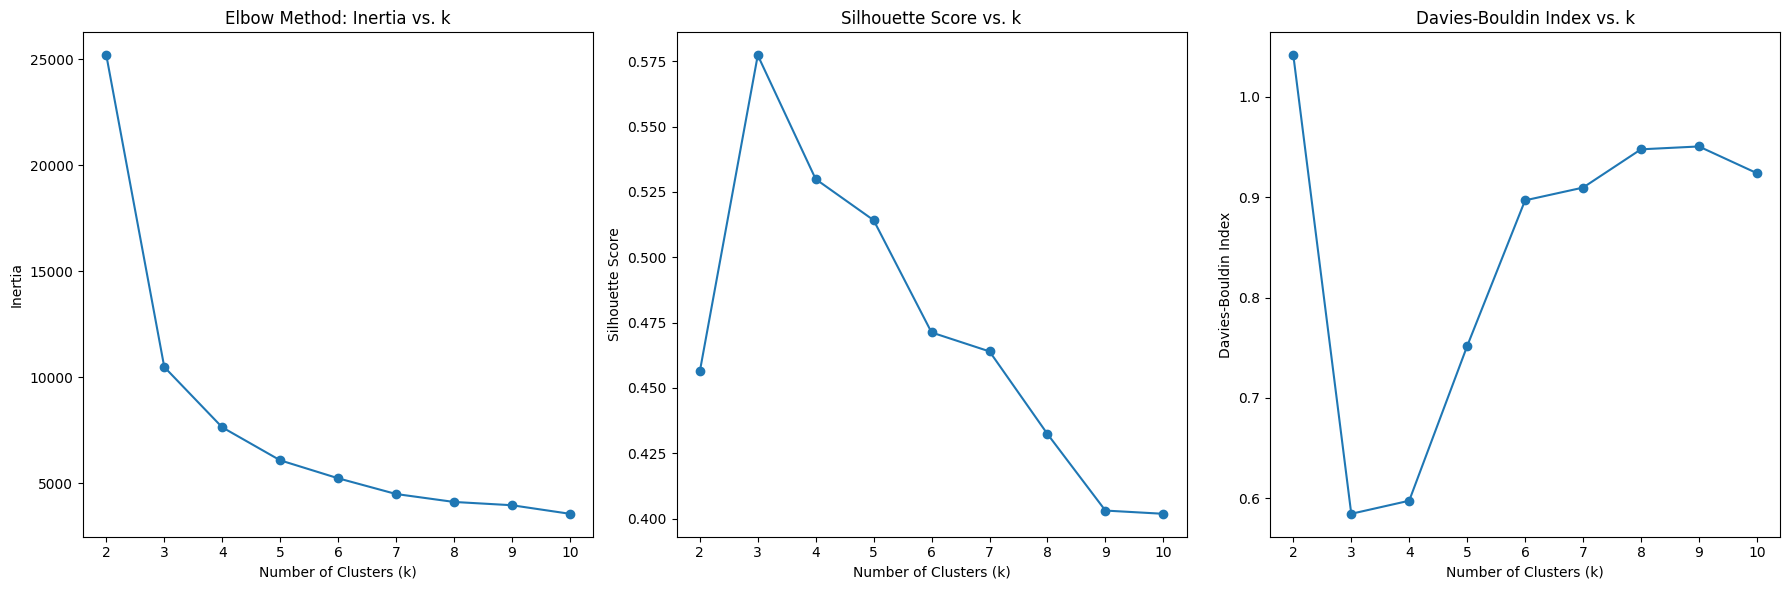

In [6]:
# Range of k values to test
k_values = range(2, 11)

# Store performance metrics
inertia_values = []
silhouette_scores = []
davies_bouldin_indices = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    y_kmeans = kmeans.fit_predict(X)
    
    # Calculate and store metrics
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, y_kmeans))
    davies_bouldin_indices.append(davies_bouldin_score(X, y_kmeans))

# Plot the inertia values (Elbow Method)
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method: Inertia vs. k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

# Plot silhouette scores
plt.subplot(1, 3, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

# Plot Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(k_values, davies_bouldin_indices, marker='o')
plt.title('Davies-Bouldin Index vs. k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

### Exercise 2. What do these results suggest to you?


<details><summary>Click here for some observations</summary>
The first plot is often used in the 'elbow method,' where the ideal value of k is chosen near the point where the curve starts to level off. Since inertia decreases as the number of clusters increases, it’s important to find the balance where adding more clusters provides diminishing returns in reducing inertia.

The inertia plot points to an optimal cluster number around 3 or 4. The silhouette score shows a clear peak at k = 3, while the Davies-Bouldin index reaches its lowest values between k = 3 and k = 4.

Overall, these metrics suggest that three clusters may be optimal, although we know that the true number of clusters in this case is actually four.


### Exercise 3. Plot the blobs and the clustering results for k = 3, 4, and 5


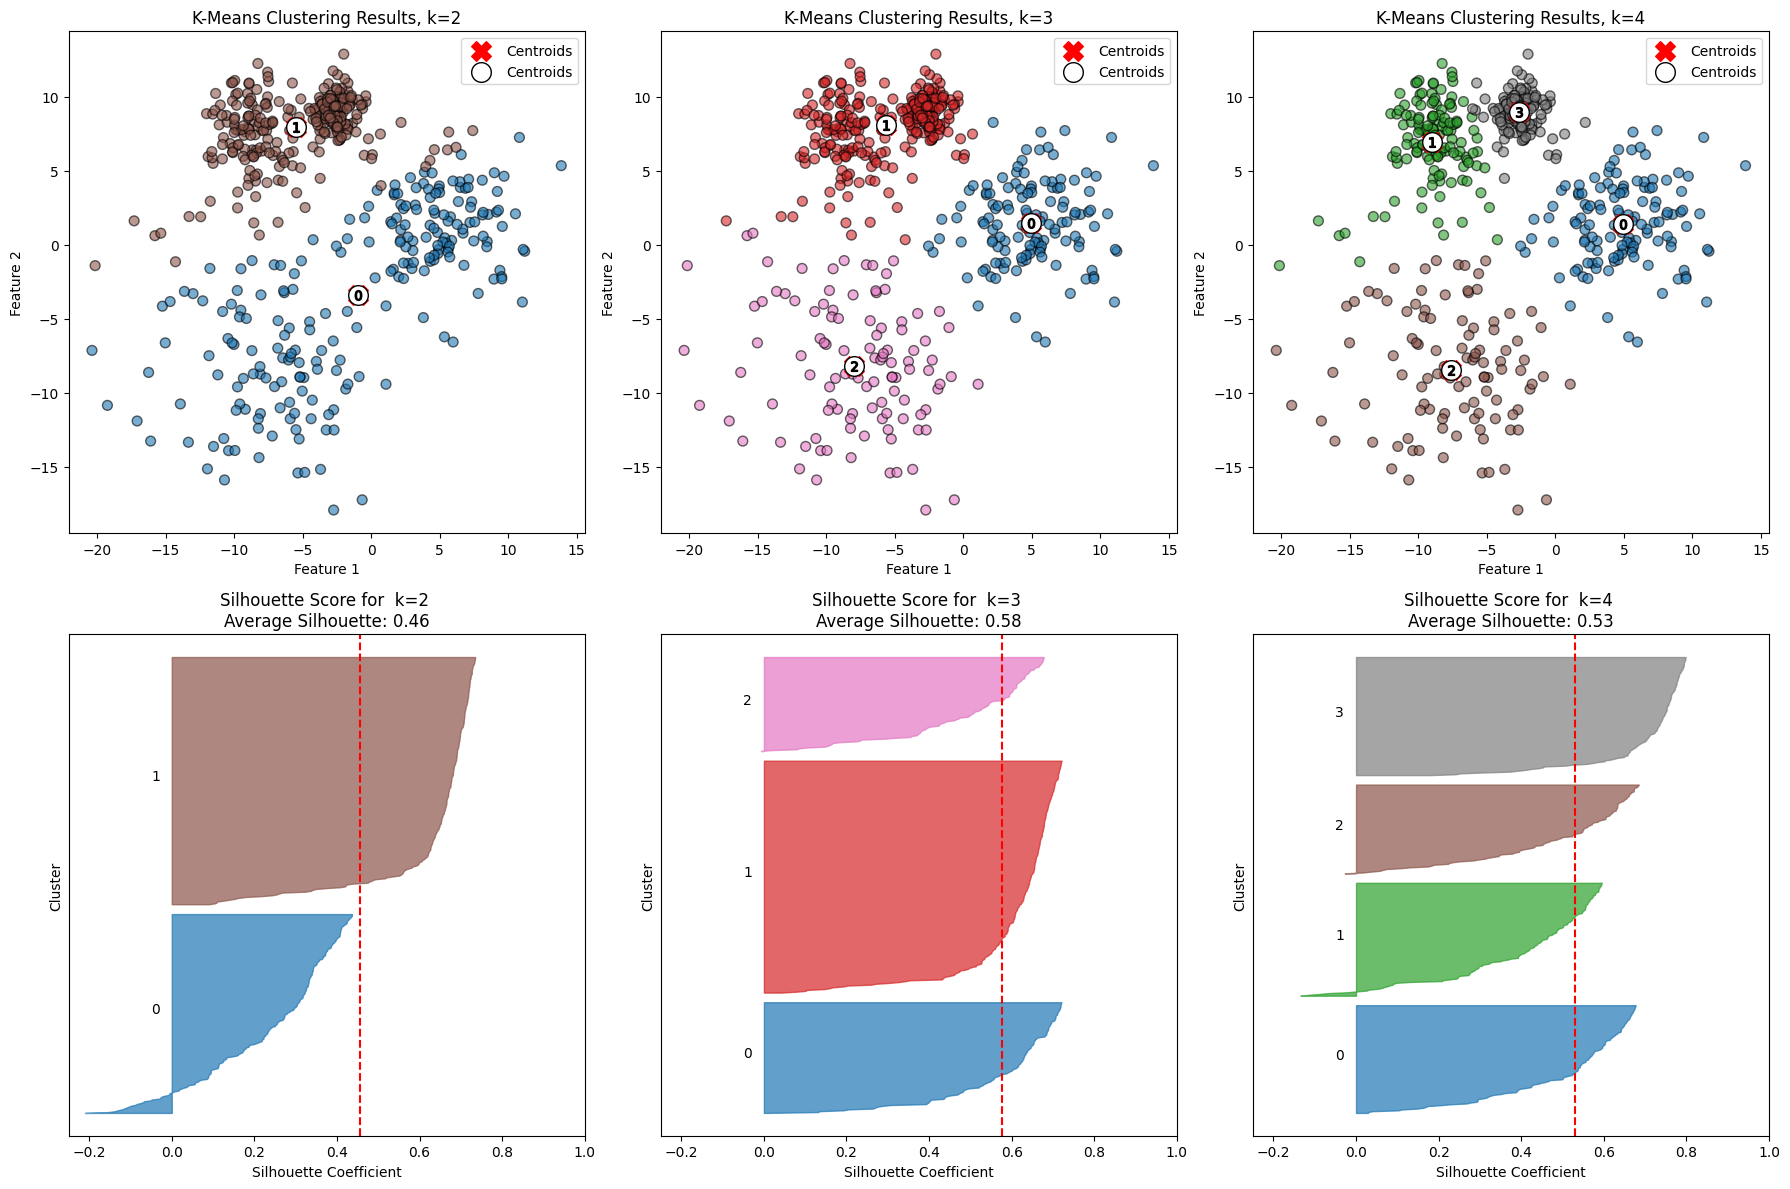

In [8]:
# Enter your code here

plt.figure(figsize=(18, 12))
colormap = cm.tab10  # Define the colormap

for i, k in enumerate([2, 3, 4]):
    # Fit KMeans and predict labels
    kmeans = KMeans(n_clusters=k, random_state=42)
    y_kmeans = kmeans.fit_predict(X)

    # Create colors based on the predicted labels
    colors = colormap(y_kmeans.astype(float) / k)

    # Scatter plot for each k in the first row (1, 2, 3)
    ax1 = plt.subplot(2, 3, i + 1)
    ax1.scatter(X[:, 0], X[:, 1], c=colors, s=50, alpha=0.6, edgecolor='k')
    ax1.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='X', label='Centroids')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    plt.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
        label='Centroids'
    )

    for i_, c in enumerate(centers):
        plt.scatter(c[0], c[1], marker="$%d$" % i_, alpha=1, s=50, edgecolor="k")

    ax1.set_title(f'K-Means Clustering Results, k={k}')
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    ax1.legend()

    # Silhouette plot for each k in the second row (4, 5, 6)
    ax2 = plt.subplot(2, 3, i + 4)
    evaluate_clustering(X, y_kmeans, k, ax=ax2, title_suffix=f' k={k}')

plt.tight_layout()  # Adjust spacing between plots
plt.show()

<details><summary>Click here for the solution</summary>

```python
plt.figure(figsize=(18, 12))
colormap = cm.tab10  # Define the colormap

for i, k in enumerate([2, 3, 4]):
    # Fit KMeans and predict labels
    kmeans = KMeans(n_clusters=k, random_state=42)
    y_kmeans = kmeans.fit_predict(X)

    # Create colors based on the predicted labels
    colors = colormap(y_kmeans.astype(float) / k)

    # Scatter plot for each k in the first row (1, 2, 3)
    ax1 = plt.subplot(2, 3, i + 1)
    ax1.scatter(X[:, 0], X[:, 1], c=colors, s=50, alpha=0.6, edgecolor='k')
    ax1.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='X', label='Centroids')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    plt.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
        label='Centroids'
    )

    for i_, c in enumerate(centers):
        plt.scatter(c[0], c[1], marker="$%d$" % i_, alpha=1, s=50, edgecolor="k")

    ax1.set_title(f'K-Means Clustering Results, k={k}')
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    ax1.legend()

    # Silhouette plot for each k in the second row (4, 5, 6)
    ax2 = plt.subplot(2, 3, i + 4)
    evaluate_clustering(X, y_kmeans, k, ax=ax2, title_suffix=f' k={k}')

plt.tight_layout()  # Adjust spacing between plots
plt.show()
``


### Exercise 4. Are these results consistent with our previous results, where we analyzed the evaluation metric plots against k?


<details><summary>Click here for the solution</summary>

By examining the clustering results for k = 2, 3, and 4, it becomes apparent that the intuitive choice for the optimal number of clusters is four, although one could also argue for three. For k=3, the first cluster fails to distinguish between two regions with varying densities, whereas for k=4, these regions are split into two distinct clusters (clusters 1 and 3).

The silhouette plot for k=4 shows relatively uniform block widths across clusters, suggesting clusters of similar sizes. However, the shape of these blocks indicates that many points are somewhat ambiguously assigned, highlighting that the clusters are not distinctly separated and may overlap to some extent.

Determining the 'correct' number of clusters is not straightforward, as it often involves subjective judgment. Metrics alone point to k=3 as being optimal, given that the silhouette plot for k=3 shows better cluster separation, with higher and more consistent silhouette scores across clusters compared to other choices for k.


### Limitations of k-means - Shape sensitivity
Can you identify situations where K-means would not be appropriate? What alternatives could be used?

Let's explore these questions with an experiment. Using `make_classification` we'll create a labelled, 2-d dataset cosisting of three classes. This time we'll have differently shaped sets of points in each class, not just spherical blobs.


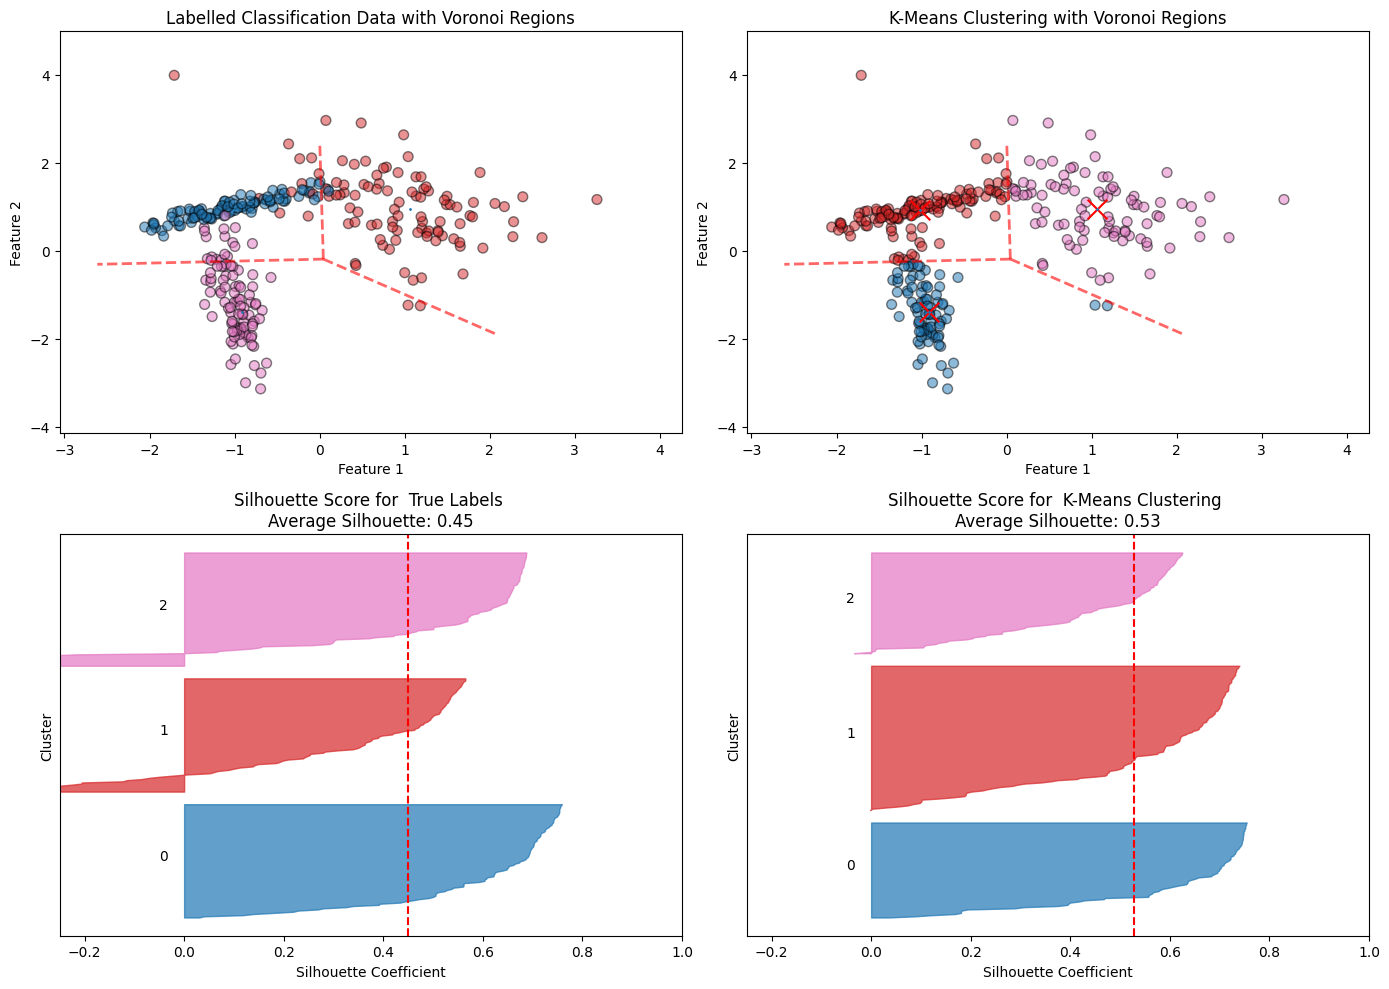

In [9]:
# Generate synthetic classification data
X, y_true = make_classification(n_samples=300, n_features=2, n_informative=2, n_redundant=0,
                                n_clusters_per_class=1, n_classes=3, random_state=42)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
y_kmeans = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

# Compute the Voronoi diagram
vor = Voronoi(centroids)

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Get consistent axis limits for all scatter plots
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# Plot the true labels with Voronoi regions
colormap = cm.tab10
colors_true = colormap(y_true.astype(float) / 3)
axes[0, 0].scatter(X[:, 0], X[:, 1], c=colors_true, s=50, alpha=0.5, ec='k')
voronoi_plot_2d(vor, ax=axes[0, 0], show_vertices=False, line_colors='red', line_width=2, line_alpha=0.6, point_size=2)
axes[0, 0].set_title('Labelled Classification Data with Voronoi Regions')
axes[0, 0].set_xlabel('Feature 1')
axes[0, 0].set_ylabel('Feature 2')
axes[0, 0].set_xlim(x_min, x_max)
axes[0, 0].set_ylim(y_min, y_max)

# Call evaluate_clustering for true labels
evaluate_clustering(X, y_true, n_clusters=3, ax=axes[1, 0], title_suffix=' True Labels')

# Plot K-Means clustering results with Voronoi regions
colors_kmeans = colormap(y_kmeans.astype(float) / 3)
axes[0, 1].scatter(X[:, 0], X[:, 1], c=colors_kmeans, s=50, alpha=0.5, ec='k')
axes[0, 1].scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='x', label='Centroids')
voronoi_plot_2d(vor, ax=axes[0, 1], show_vertices=False, line_colors='red', line_width=2, line_alpha=0.6, point_size=2)

axes[0, 1].set_title('K-Means Clustering with Voronoi Regions')
axes[0, 1].set_xlabel('Feature 1')
axes[0, 1].set_ylabel('Feature 2')
axes[0, 1].set_xlim(x_min, x_max)
axes[0, 1].set_ylim(y_min, y_max)

# Call evaluate_clustering for K-Means labels
evaluate_clustering(X, y_kmeans, n_clusters=3, ax=axes[1, 1], title_suffix=' K-Means Clustering')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


### Exercise 5. What can you say about this result?
How well did k-means replicate the classes in this experiment? What are some considerations for different approaches?


<details><summary>Click here for the solution</summary>
K-means did a good job of identifying three clusters that mostly agree with the three classses. 
    
However, looking at the finer details, k-means wasn't able to fully capture the inherent coherence of the two linearly shaped classes (purple and green). 

Another thing to notice is that the clusters are partitioned in a way that doesn't capture the density of the classes.

The red dashed lines in the scatter plots indicate the boundaries between the "voronoi" regions that separate the clusters.
It's not clear why the two purple points on the lower portion of the yellow cluster were mislabelled. 
Similarly, the green points between the two green and purple clusters were mislabeled.

Interestingly, the silhoutte score is higher for the clustering result than it it for the actual class labels. This is appropriate though since the actual classes slightly overlap, as is also indicated by the negative values in the silhoutte plot for the pink and red classes.

Go ahead and explore some different approaches. Of course, in real world clustering problems, you don't have the benefit of knowing the answer like we did in this experiment, so you will need to be creative.The K-means algorithm performed reasonably well in identifying three clusters that mostly align with the true class labels. However, a closer examination reveals that K-means struggles to accurately capture the elongated, linear structure of the two classes (represented in purple and green).

One notable limitation is that K-means does not effectively account for the density distribution of points. The resulting clusters are separated by "Voronoi" boundaries (indicated by the red dashed lines), which split the space into regions that are equidistant to the nearest centroids. This approach inherently assumes spherical shapes for clusters and can misclassify points if the true distribution deviates from this assumption.

For instance, the two purple points within the lower section of the yellow cluster were misclassified. Similarly, some green points situated between the main green and purple clusters were also labeled incorrectly. This highlights K-means' inability to fully respect the density-based continuity of data.

A more flexible clustering approach, such as DBSCAN (Density-Based Spatial Clustering of Applications with Noise), might be more suitable for this type of data. DBSCAN takes density into account and can identify clusters of varying shapes and sizes, potentially capturing the true structure of the data more effectively.

In real-world clustering tasks, the ground truth is not known, so exploring multiple algorithms and adapting them to the specific data characteristics is essential. Testing different methods like DBSCAN or hierarchical clustering, which consider density and proximity in non-linear ways, could provide better results for complex datasets.


### Congratulations! You're ready to move on to your next lesson!


## Author

<a href="https://www.linkedin.com/in/jpgrossman/">Jeff Grossman</a>

### Other Contributors

<a href="https://www.linkedin.com/in/abhishek-gagneja-23051987/">Abhishek Gagneja</a>



<!-- ## Changelog

| Date | Version | Changed by | Change Description |
|:------------|:------|:------------------|:---------------------------------------|
| 2024-11-05 | 1.0  | Jeff Grossman    | Create content |
| 2024-12-03 | 1.1  | Abhishek Gagneja | Typos corrected |
| 2025-05-09 | 1.2  | Anita Verma | Fixed identation |
 -->


## <h3 align="center"> © IBM Corporation. All rights reserved. <h3/>
